In [1]:
# 1:54:49.48 to get a functioning encoding with just compartmental constraints.  Needs more time on probing the parameters
# 0 - 32:00.68: Setup basic encoding
# 32:00.68 - 48:00: Setup z3 solver and get results
# 48:00 - 1:27:15: Setup solution extraction
# 1:27:15 - 1:54:49.48: Setup solution plotting and explore 8 parameter bound settings to test
# 1:54:49.48 - 2:09:43.40: Cleanup code, comments, and improve plotting to interpolate
# 2:09:43.40 - 2:17:19.51: Add dreal and test

from pysmt.shortcuts import And, Or, Plus, Minus, Times, Div, REAL, LE, LT, GE, GT, Equals, Symbol, Real, Solver
from pysmt.fnode import  FNode
from typing import Dict
import pandas as pd
from decimal import Decimal
import numpy as np


def dataframe(assignment: Dict[Symbol, float], state_variables, parameters, timepoints) -> pd.DataFrame:
    timeseries = {sv: [None]*len(timepoints) for sv in state_variables}
    for k, v in assignment.items():
        sym = k.symbol_name()
        if "_" in sym:
            sv = sym.split("_")[0]
            t = sym.split("_")[1]
            value =Decimal(v.numerator) / Decimal(v.denominator)
            timeseries[sv][timepoints.index(int(t))] = value
        else:
            timeseries[sym] = [v]*len(timepoints)
    df = pd.DataFrame(timeseries, index=timepoints).astype(float)
    return df

def reindex_and_interpolate(df, new_index):
    df_reindexed = df.reindex(index = new_index)
    df_reindexed.interpolate(method = 'linear', inplace = True)
    return df_reindexed


def plot_results(values, timepoints):
    results: pd.DataFrame = dataframe(values, ["S", "I", "R"], ["beta", "gamma"], list(timepoints))
    newindex = np.linspace(timepoints[0], timepoints[-1], timepoints[-1]+1)
    results = reindex_and_interpolate(results, newindex)
    print(f"beta = {results['beta'][0]}, gamma = {results['gamma'][0]}")
    print(results[["S", "I", "R"]])
    ax = results[["S", "I", "R"]].plot()
    ax.set_xlabel="Time"
    return ax

def run_solver(solver):
    solver.add_assertion(consistency)
    result = solver.solve()
    if result:
        model = solver.get_model()
        variables = consistency.get_free_variables()
        values = {}
        for var in variables:
            try:
                values[var] = model.get_value(var).constant_value()
            except Exception as e:
                pass
    else:
        print("Unsat")
        values = None
    return values



In [2]:
# Configure these bounds (lower, upper) to configure the parameter space

beta_bounds = (0.0, 0.01)
gamma_bounds = (0.0, 0.2)

# Set these values for the initial state

S_0_value = 1000
I_0_value = 1
R_0_value = 0


# Timepoints
step_size = 10
max_time = 100

In [3]:
# The main encoding code, which includes 

time_format = lambda t: f"{t:03d}"


################################################################################
################# Initial States ###############################################
################################################################################

S_0 = Symbol(f"S_{time_format(0)}", REAL)
I_0 = Symbol(f"I_{time_format(0)}", REAL)
R_0 = Symbol(f"R_{time_format(0)}", REAL)

population_size = S_0_value + I_0_value + R_0_value

# SIR Model Initial State
initial_state = And([
    Equals(S_0, Real(S_0_value)),
    Equals(I_0, Real(I_0_value)),
    Equals(R_0, Real(R_0_value))
])

################################################################################
################# Parameters     ###############################################
################################################################################


# Parameters
beta = Symbol("beta", REAL)

gamma = Symbol("gamma", REAL)


parameters = And([
    And(LE(Real(beta_bounds[0]), beta), LT(beta, Real(beta_bounds[1]))),
    And(LE(Real(gamma_bounds[0]), gamma), LT(gamma, Real(gamma_bounds[1])))
])


timepoints = list(range(0, max_time+step_size, step_size))


################################################################################
################# Transitions ##################################################
################################################################################

S_next = lambda t: Symbol(f"S_{time_format(t+step_size)}", REAL)
S_now = lambda t: Symbol(f"S_{time_format(t)}", REAL)
I_next = lambda t: Symbol(f"I_{time_format(t+step_size)}", REAL)
I_now = lambda t: Symbol(f"I_{time_format(t)}", REAL)
R_next = lambda t: Symbol(f"R_{time_format(t+step_size)}", REAL)
R_now = lambda t: Symbol(f"R_{time_format(t)}", REAL)
dt = Real(float(step_size))

S_Trans = lambda t: Equals(S_next(t), 
                                Minus(
                                    S_now(t), 
                                    Times([beta, S_now(t), I_now(t), dt])))

I_Trans = lambda t: Equals(I_next(t), 
                                Plus(
                                    I_now(t), 
                                    Times(
                                        Minus(
                                            Times([beta, S_now(t), I_now(t)]), 
                                            Times(gamma, I_now(t))), dt)))

R_Trans = lambda t: Equals(R_next(t), 
                                Plus(
                                    R_now(t), 
                                    Times(
                                        Times(gamma, I_now(t)), 
                                        dt)))

Trans = lambda t: And(S_Trans(t), I_Trans(t), R_Trans(t))

All_Trans = And([Trans(t) for t in timepoints[:-1]])


################################################################################
################# Constraints ##################################################
################################################################################

compartmental_constraint = And([
    And( LE(Real(0.0), S_now(t)),
    LE(Real(0.0), I_now(t)),
    LE(Real(0.0), R_now(t)),
    Equals(Plus([S_now(t), I_now(t), R_now(t)]), Real(population_size)))
 for t in timepoints])


################################################################################
################# Combine Assertions ###########################################
################################################################################

consistency = And([
    initial_state,
    parameters,
    All_Trans,
    compartmental_constraint
    ])
# consistency.serialize()

beta = 9.00900900900901e-05, gamma = 0.1900900900900901
                 S    I         R
0.0    1000.000000  1.0  0.000000
1.0     999.909910  0.9  0.190090
2.0     999.819820  0.8  0.380180
3.0     999.729730  0.7  0.570270
4.0     999.639640  0.6  0.760360
...            ...  ...       ...
96.0    999.099099  0.0  1.900901
97.0    999.099099  0.0  1.900901
98.0    999.099099  0.0  1.900901
99.0    999.099099  0.0  1.900901
100.0   999.099099  0.0  1.900901

[101 rows x 3 columns]


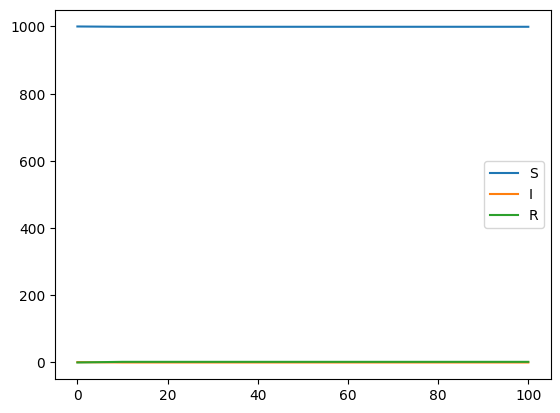

In [4]:
# Solve encoding
with Solver() as solver:
    values = run_solver(solver)
    
if values:
    plot_results(values, timepoints)


beta = 0.0001832047664402712, gamma = 0.19637933240403038
                 S         I          R
0.0    1000.000000  1.000000   0.000000
1.0     999.816795  0.986789   0.196379
2.0     999.633590  0.973577   0.392759
3.0     999.450386  0.960366   0.589138
4.0     999.267181  0.947154   0.785517
...            ...       ...        ...
96.0    989.957889  0.229677  10.812571
97.0    989.912094  0.225855  10.862214
98.0    989.866299  0.222034  10.911856
99.0    989.820504  0.218212  10.961499
100.0   989.774710  0.214391  11.011141

[101 rows x 3 columns]


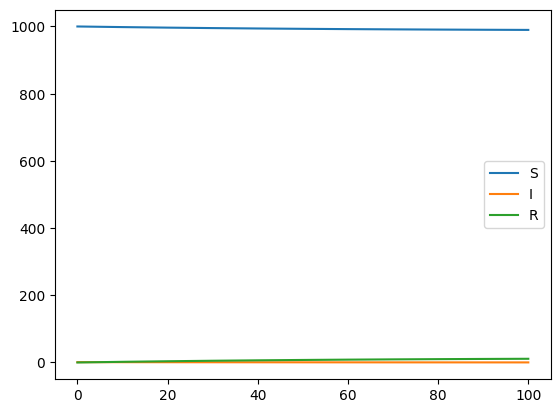

In [12]:

# Use dreal instead of z3
from pysmt.logics import QF_NRA

from funman_dreal.solver import ensure_dreal_in_pysmt

ensure_dreal_in_pysmt()

opts = {
        "dreal_precision": 1e-3,
        "dreal_log_level": "none",
        "dreal_mcts": True,
    }
with Solver(name="dreal",
            logic=QF_NRA,
            solver_options=opts
            ) as solver:
    values = run_solver(solver)
    
if values:
    plot_results(values, timepoints)
